In [1]:
# Performing classification on the MNIST dataset
# MNIST dataset - 70000 small images of handwritten digits with corresponding label
# Can be downloaded straight through Scikit-Learn:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# DESCR key - describes the dataset
# data key - array with one row per instance and one column per feature
# target key - array containing the labels

X, y = mnist["data"], mnist["target"]
print("Size X: ", X.shape, " , Size Y: ", y.shape)

Size X:  (70000, 784)  , Size Y:  (70000,)


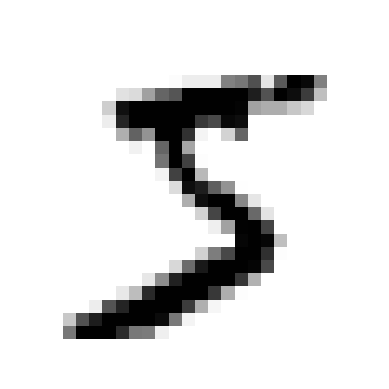

Label:  5


In [14]:
# -> 70000 images and each image has 784 features (image = 28x28 pixels) - each features represents one pixel's intensity (0 - 255)
# let's display one image:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].to_numpy()
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
print("Label: ",  y[0])

In [17]:
import numpy as np
# Currently - label is a string
print(type(y[0]))
# convert it to integers
y = y.astype(np.uint8)

<class 'str'>


In [22]:
# Creating a train (first 60000) and test (last 10000) sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# Training set is already shuffeled - guarantees all cross-validation folds will be similar (i.e. you dont want one fold to be missing some digits)
# Additionally, some algorithms are sensitive to order of the training instances - perform poorly when many similar instances in a row
# However, shuffling can also be a bad idea - especially for time series data, e.g. stock market prices / weather

In [23]:
# Training a Binary Classifier
# Simplified problem - identifiyng one digit, i.e. 5 -> "5-Detector": 5 or not 5
# Target vectors:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [24]:
# Options:
# Stochastic Gradient Descent (SGD) - can handle very large datasets efficiently, deals with training instances independently (one at the time)
from sklearn.linear_model import SGDClassifier
# random_state parameter - ensure that the "randomness" is always the same for the stochastic classifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [25]:
# test
sgd_clf.predict([some_digit])

C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [32]:
# Performance Measures - trickier for classifiers than regressors - many performance measures available
# 1) Using cross-validation: implementing from scratch - when you need more control over the process
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Performed stratified sampling - for folds with representative ratio of each class
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [33]:
# Let's use built in cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [34]:
# Classifier looks very good - 95% accuracy
# But first lets test a vary dumb classifier that labels all images as "not-5"
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

# Test the accuracy:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [ ]:
# 90% accuracy - simply beacuse only about 10% of images are 5s
# Demonstates why accuracy is generally not the preferred performance measure for classifiers when dealing with skewed datasets
# Meaning when some classes are much more frequent than others